<a href="https://colab.research.google.com/github/antonioalonsocr/food_sales_predictions/blob/main/ItemSalesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Get the data and superficially analyze

In [3]:
food_df = pd.read_csv('/content/drive/MyDrive/CodingDojo/Project1/sales_predictions.csv')

In [4]:
food_df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [5]:
food_df.isna().any()

Item_Identifier              False
Item_Weight                   True
Item_Fat_Content             False
Item_Visibility              False
Item_Type                    False
Item_MRP                     False
Outlet_Identifier            False
Outlet_Establishment_Year    False
Outlet_Size                   True
Outlet_Location_Type         False
Outlet_Type                  False
Item_Outlet_Sales            False
dtype: bool

# Dive deeper into analysis

In [6]:
# Seems like Low Fat = LF = low fat         and          Regular = reg

food_df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [7]:
# Item_Weight and Outlet_Size are the only columns with NaN values
# ignoring the rows where NaN values are found would be unwise, as they represent a large percentage of the rows
# how the Item_Weight and Outlet_Size columns will be used is still not defined, so there is a possibility that these columns can be ignored

# Randomly assigning values to the missing values would also be unwise, because with this many missing values it might confuse a ML algorithm

food_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [8]:
# No capitalization (or other types of) differences

food_df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [9]:
# Grocery Stores have the lowest Item_Outlet_Sales by far, with Type2 following, then Type1, then Type3 with a large lead
# Perhaps this could be a method to find what the missing values in Outlet_Type are?

food_df.groupby(['Outlet_Type'])[['Item_Outlet_Sales']].mean()

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


# Start cleaning the data and issues found in analysis

## Item_Fat_Contents separate values for same meaning

In [10]:
# For Item_Fat_Content, we want to turn the 5 different values into only two ('Low Fat' and 'Regular')
LF_filter = food_df['Item_Fat_Content'] == 'LF'
lowfat_filter = food_df['Item_Fat_Content'] == 'low fat'

In [11]:
food_df.loc[LF_filter | lowfat_filter,'Item_Fat_Content'] = 'Low Fat'

In [12]:
food_df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    2889
reg         117
Name: Item_Fat_Content, dtype: int64

In [13]:
reg_filter = food_df['Item_Fat_Content'] == 'reg'

In [14]:
food_df.loc[reg_filter,'Item_Fat_Content'] = 'Regular'

In [15]:
food_df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [16]:
# To determine statistical significance more analysis is required, but it seems as though Low Fat has a slightly lower Item_Outlet_Sales mean than Regular

food_df.groupby(['Item_Fat_Content'])[['Item_Outlet_Sales']].mean()

,Item_Outlet_Sales
Item_Fat_Content,
Low Fat,2157.711534
Regular,2224.561170


## Imputing missing values

In [17]:
# Some problems with imputing values from Outlet_Size are:
#   the values are discrete, there are only 3 possible levels ('Small', 'Medium', 'High')
#   there are many rows with missing data
#   it is possible that the outlet size does not affect other factors, so guessing is not possible for humans, and machines might have a hard time with it

In [18]:
food_df.groupby(['Outlet_Type'])[['Item_Outlet_Sales']].mean()

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


In [19]:
# We have found that there is a relationship between Item_Outlet_Sales
# and Outlet_Type, so sorting them first before interpolating values should
# yield a more accurate filling in of missing values

food_df.sort_values('Item_Outlet_Sales',inplace=True)

In [20]:
food_df['Outlet_Size'] = food_df['Outlet_Size'].interpolate(method='bfill')

In [21]:
# This graph shows very little to no visible correlation between the Item_Weights and the sales
# therefore, before interpolating 
fig = px.density_contour(food_df, x='Item_Weight',y='Item_Outlet_Sales',marginal_x='histogram',marginal_y='histogram')
fig.show()

In [22]:
food_df['Item_Weight'] = food_df['Item_Weight'].interpolate()

In [23]:
food_df.sort_index(inplace=True)

In [24]:
food_df.isna().any()

Item_Identifier              False
Item_Weight                  False
Item_Fat_Content             False
Item_Visibility              False
Item_Type                    False
Item_MRP                     False
Outlet_Identifier            False
Outlet_Establishment_Year    False
Outlet_Size                  False
Outlet_Location_Type         False
Outlet_Type                  False
Item_Outlet_Sales            False
dtype: bool

In [25]:
food_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Exploratory Data Analysis

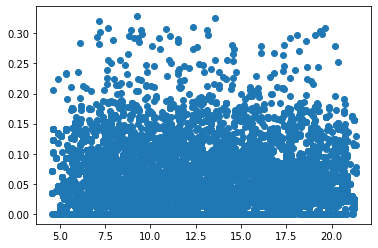

In [26]:
# For the missing values in Item_Weight, I would like to plot a graph of the weights and some other variable, perhaps finding some correlation.
plt.scatter(x=food_df['Item_Weight'],y=food_df['Item_Visibility'])

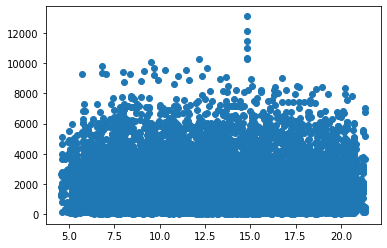

In [27]:
# There seems to be no easily found relationship between Item_Weight and either of these continuous variables
plt.scatter(x=food_df['Item_Weight'],y=food_df['Item_Outlet_Sales'])

In [28]:
food_df.head(1)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.138


In [29]:
food_df.groupby(['Item_Fat_Content'])[['Item_Outlet_Sales']].mean()

,Item_Outlet_Sales
Item_Fat_Content,
Low Fat,2157.711534
Regular,2224.561170


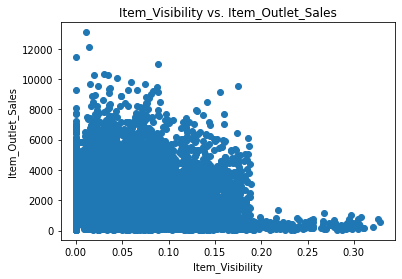

In [30]:
# After a certain amount of visibility, total revenue from the item seems to be stagnant.
plt.scatter(x=food_df['Item_Visibility'],y=food_df['Item_Outlet_Sales']);
plt.title('Item_Visibility vs. Item_Outlet_Sales');
plt.xlabel('Item_Visibility');
plt.ylabel('Item_Outlet_Sales');

In [31]:
food_df.groupby(['Item_Type'])[['Item_Outlet_Sales']].mean()

,Item_Outlet_Sales
Item_Type,
Baking Goods,1952.971207
Breads,2204.132226
Breakfast,2111.808651
Canned,2225.194904
Dairy,2232.542597
Frozen Foods,2132.867744
Fruits and Vegetables,2289.009592
Hard Drinks,2139.221622
Health and Hygiene,2010.000265


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text major ticklabel objects>)

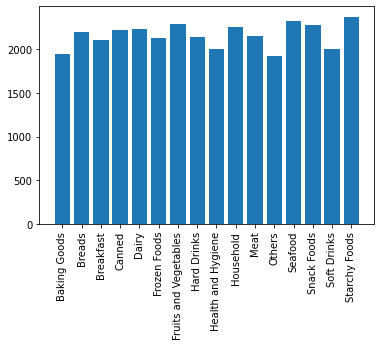

In [32]:
# Manually making a list of the values, because otherwise it was giving me an error
myheight = [1952.971207, 2204.132226, 2111.808651, 2225.194904, 2232.542597, 2132.867744, 2289.009592, 2139.221622, 2010.000265, 2258.784300, 2158.977911, 1926.139702,
2326.065928, 2277.321739, 2006.511735, 2374.332773]
############################# CHECK FOR A BETTER WAY TO DO THIS ##################################

plt.bar(x = list(food_df.groupby(['Item_Type'])[['Item_Outlet_Sales']].mean().index), height = myheight)
plt.xticks(rotation=90)

# There does not seem to be a lot of variation on the Item_Outlet_Sales, but maybe that small difference is significant.

In [33]:
# As mentioned earlier:

# Grocery Stores have the lowest Item_Outlet_Sales by far, with Type2 following, then Type1, then Type3 with a large lead
# Perhaps this could be a method to find what the missing values in Outlet_Type are?

food_df.groupby(['Outlet_Type'])[['Item_Outlet_Sales']].mean()

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


# Explanatory Data Analysis

In [34]:
fig = px.density_contour(food_df, x='Item_Visibility',y='Item_Outlet_Sales',marginal_x='histogram',marginal_y='histogram')
fig.show()

# What can be taken away from this density contour plot is that a higher Item_Visibility values tends to indicate lower Item_Outlet_Sales
# and even though most of the samples have low item_visibility AND low item_outlet_sales, it appears as though only items with low visibility
# have high outlet sales (though, once again, not most items with low visibility have low item outlet sales anyway).

In [35]:
fig = px.bar(food_df, x='Item_Type', y="Item_Outlet_Sales", color='Outlet_Type', barmode="group")
fig.show()

# This separation by colors helps us see that Type1 supermarkets lead total Item_Outlet_Sales in our data set, followed by Type3, then Type2, then Grocery Store
# Also, we are able to see where most of the revenue comes from for each individual type of outlet.

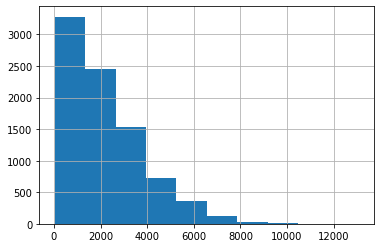

In [36]:
food_df['Item_Outlet_Sales'].hist()

In [37]:
food_df['Item_Outlet_Sales'].median()

1794.3310000000001

In [38]:
# 2000 is somewhat aribitrarily chosen, but keeping
# in mind that themedian is slightly lower, at 1800

highsale_filter = food_df['Item_Outlet_Sales'] >= 2000

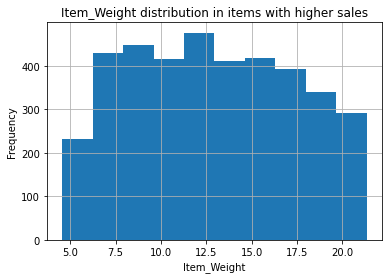

In [39]:
food_df.loc[highsale_filter, 'Item_Weight'].hist()
plt.title('Item_Weight distribution in items with higher sales')
plt.xlabel('Item_Weight')
plt.ylabel('Frequency');

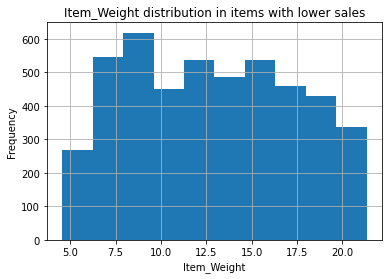

In [40]:
food_df.loc[~highsale_filter, 'Item_Weight'].hist()
plt.title('Item_Weight distribution in items with lower sales')
plt.xlabel('Item_Weight')
plt.ylabel('Frequency');

No noticeable difference between the two distributions

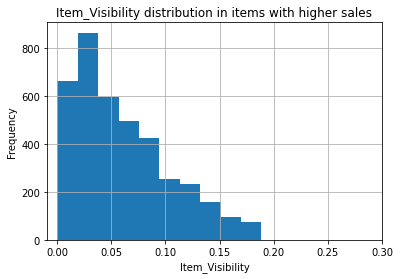

In [41]:
food_df.loc[highsale_filter, 'Item_Visibility'].hist()
plt.title('Item_Visibility distribution in items with higher sales')
plt.xlabel('Item_Visibility')
plt.ylabel('Frequency')
plt.xticks([0.0,0.05,0.1,0.15,0.2,0.25,0.3]);

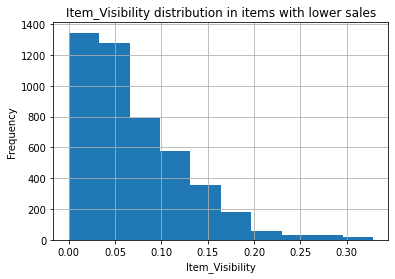

In [42]:
food_df.loc[~highsale_filter, 'Item_Visibility'].hist()
plt.title('Item_Visibility distribution in items with lower sales')
plt.xlabel('Item_Visibility')
plt.ylabel('Frequency')
plt.xticks([0.0,0.05,0.1,0.15,0.2,0.25,0.3]);

Slightly noticeable difference, items with low sales seem to have item visibilities skewed slightly to the left

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



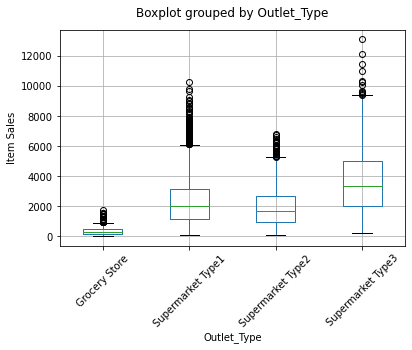

In [43]:
food_df.boxplot(column = 'Item_Outlet_Sales', by = 'Outlet_Type');
plt.title('')
plt.xticks(rotation = 45)
plt.ylabel('Item Sales');

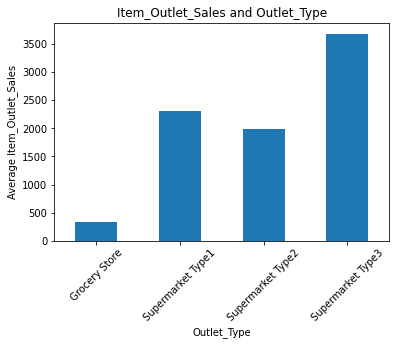

In [44]:
food_df.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().plot(kind='bar',ylabel='Average Item_Outlet_Sales',title='Item_Outlet_Sales and Outlet_Type');
plt.xticks(rotation=45);

# Machine learning

## Setting up the data

In [45]:
food_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

In [47]:
food_df.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.008593,0.021548,-0.002141,0.005118
Item_Visibility,-0.008593,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.021548,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.002141,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.005118,-0.128625,0.567574,-0.049135,1.000000


I want to define my features and my target vector. Defining the features matrix while having categorical data means I will use encoding techniques, primarily one hot encoding, as this seems to be both the easiest to implement and an effective solution<br><br>

Firstly, I want to define the columns I want to include in my matrix
and what the target vector will be:<br>
**Target:** Item_Outlet_Sales <br>
**Features:** Item_Weight, *Item_Fat_Content*, Item_Visibility, *Item_Type*, Item_MRP, *Outlet_Type*<br>
Where features that are *italicized* mean they are object types; these must be dealt with and the main way to deal with these will be to use the one hot encoding technique

In [48]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

X = food_df.loc[:,['Item_Weight','Item_Fat_Content','Item_Visibility', 'Item_Type','Item_MRP', 'Outlet_Type']]
y = food_df['Item_Outlet_Sales']

# Before starting the one hot encoding process, I want to change the Item_Fat_Content column
# because there are only two values here; what I want to do is make a regular fat content a 1,
# and a low fat content a 0

X['Item_Fat_Content_Num'] = np.zeros(shape=X['Item_Fat_Content'].shape)
X.loc[X['Item_Fat_Content'] == 'Regular',['Item_Fat_Content_Num']] = 1

tryx = X[['Item_Type','Outlet_Type']]

ohe = OneHotEncoder(sparse=False)
X_train_ohe = ohe.fit_transform(tryx)

X.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Type,Item_Fat_Content_Num
0,9.30,Low Fat,0.016047,Dairy,249.8092,Supermarket Type1,0.0
1,5.92,Regular,0.019278,Soft Drinks,48.2692,Supermarket Type2,1.0
2,17.50,Low Fat,0.016760,Meat,141.6180,Supermarket Type1,0.0
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,Grocery Store,1.0
4,8.93,Low Fat,0.000000,Household,53.8614,Supermarket Type1,0.0


In [49]:
food_df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [50]:
fullX = pd.DataFrame(X_train_ohe, columns=['Baking Goods',
                                       'Breads',
                                       'Breakfast',
                                       'Canned',
                                       'Dairy',
                                       'Frozen Foods',
                                       'Fruits and Vegetables',
                                       'Hard Drinks',
                                       'Health and Hygiene',
                                       'Household',
                                       'Meat',
                                       'Others',
                                       'Seafood',
                                       'Snack Foods',
                                       'Soft Drinks',
                                       'Starchy Foods',
                                       'Grocery Store',
                                       'Supermarket Type1',
                                       'Supermarket Type2',
                                       'Supermarket Type3'])

fullX['Item_Weight'] = X['Item_Weight']
fullX['Item_Visibility'] = X['Item_Visibility']
fullX['Item_MRP'] = X['Item_MRP']
fullX['Item_Fat_Content_Num'] = X['Item_Fat_Content_Num']

fullX.head()
# food_df['Item_Type'].value_counts()

,Baking Goods,Breads,Breakfast,Canned,Dairy,Frozen Foods,Fruits and Vegetables,Hard Drinks,Health and Hygiene,Household,Meat,Others,Seafood,Snack Foods,Soft Drinks,Starchy Foods,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Num
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.30,0.016047,249.8092,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,5.92,0.019278,48.2692,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,17.50,0.016760,141.6180,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,19.20,0.000000,182.0950,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.93,0.000000,53.8614,0.0


In [51]:
corrX = fullX.copy()
corrX['target'] = y


# From this, we can see that the outlet store type has an effect on the expected
# Item_Outlet_sales; Grocery store has a very high negative correlation with the sales
# and Supermarket type 3 has a relatively strong correlation with the sales.

# The most clear relationship though is in Item_MRP and Item sales.
corrX.corr().sort_values(['target'])

,Baking Goods,Breads,Breakfast,Canned,Dairy,Frozen Foods,Fruits and Vegetables,Hard Drinks,Health and Hygiene,Household,Meat,Others,Seafood,Snack Foods,Soft Drinks,Starchy Foods,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Num,target
Grocery Store,0.003536,0.002305,0.015676,-0.012574,0.006933,-0.006763,-0.004556,-0.007189,0.001361,0.003842,0.019416,0.013963,0.007621,-0.006565,-0.004031,-0.015658,1.000000,-0.524942,-0.133364,-0.133928,0.009316,0.286400,-0.004277,-0.002924,-0.411727
Item_Visibility,0.016887,0.000416,0.043418,0.011114,0.035984,-0.003153,0.018969,-0.003700,-0.053931,-0.032230,-0.017087,-0.016240,0.014910,0.005635,-0.009825,0.003688,0.286400,-0.144249,-0.034671,-0.051144,-0.008593,1.000000,-0.001315,0.047314,-0.128625
Baking Goods,1.000000,-0.049968,-0.032801,-0.082354,-0.084600,-0.095849,-0.117916,-0.046036,-0.073120,-0.099176,-0.065715,-0.040800,-0.024951,-0.116120,-0.067327,-0.038133,0.003536,0.001846,-0.003632,-0.002957,-0.033584,0.016887,-0.067311,0.083804,-0.038381
Supermarket Type2,-0.003632,-0.000734,0.000077,0.010418,-0.001746,-0.001507,0.000919,-0.003132,0.002174,-0.004979,-0.000476,0.004320,0.000138,0.001453,-0.004153,0.002553,-0.133364,-0.480943,1.000000,-0.122702,0.002536,-0.034671,0.003850,0.002129,-0.038059
Health and Hygiene,-0.073120,-0.044402,-0.029147,-0.073181,-0.075176,-0.085173,-0.104782,-0.040908,1.000000,-0.088129,-0.058396,-0.036255,-0.022172,-0.103186,-0.059828,-0.033885,0.001361,-0.005422,0.002174,0.004634,0.013145,-0.053931,-0.041646,-0.188156,-0.025587
Soft Drinks,-0.067327,-0.040885,-0.026838,-0.067383,-0.069220,-0.078425,-0.096481,-0.037667,-0.059828,-0.081147,-0.053769,-0.033383,-0.020415,-0.095011,1.000000,-0.031201,-0.004031,0.009777,-0.004153,-0.006443,-0.046494,-0.009825,-0.035808,-0.094875,-0.024040
Others,-0.040800,-0.024776,-0.016264,-0.040834,-0.041947,-0.047525,-0.058467,-0.022826,-0.036255,-0.049174,-0.032584,1.000000,-0.012372,-0.057576,-0.033383,-0.018908,0.013963,-0.006344,0.004320,-0.009533,0.025513,-0.016240,-0.018595,-0.104988,-0.021267
Frozen Foods,-0.095849,-0.058204,-0.038207,-0.095929,-0.098544,1.000000,-0.137352,-0.053624,-0.085173,-0.115523,-0.076547,-0.047525,-0.029064,-0.135260,-0.078425,-0.044418,-0.006763,0.009750,-0.001507,-0.006128,-0.006918,-0.003153,-0.013358,0.085041,-0.009482
Breakfast,-0.032801,-0.019918,1.000000,-0.032828,-0.033723,-0.038207,-0.047004,-0.018351,-0.029147,-0.039533,-0.026195,-0.016264,-0.009946,-0.046288,-0.026838,-0.015201,0.015676,-0.008695,0.000077,-0.003550,-0.001201,0.043418,0.001460,0.065711,-0.004656
Hard Drinks,-0.046036,-0.027955,-0.018351,-0.046074,-0.047330,-0.053624,-0.065970,1.000000,-0.040908,-0.055485,-0.036765,-0.022826,-0.013959,-0.064965,-0.037667,-0.021334,-0.007189,0.007837,-0.003132,-0.001143,-0.046821,-0.003700,-0.010089,-0.118461,-0.003956


In [52]:
# I want to train AND evaluate my model, so to do that I should separate my data 
# into training data and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(fullX,y)

In [53]:
scaler = StandardScaler()
# Fit on X (assuming your features matrix is a NumPy array)
scaler.fit(X_train)
# Transform X
X_train = scaler.transform(X_train);
X_test = scaler.transform(X_test)

In [54]:
print(X_train.std())
print(X_test.std())

1.0
0.9952687556119294


## KNN Model

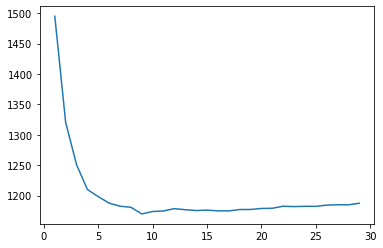

In [56]:
from sklearn.metrics import mean_squared_error

knn = KNeighborsRegressor(n_neighbors=13)
knn.fit(X_train,y_train)

estimator_range = list(range(1,30,1))
RMSElist = []

for estimator in estimator_range:
  knn=KNeighborsRegressor(n_neighbors=estimator)
  knn.fit(X_train,y_train)
  RMSElist = RMSElist + [np.sqrt(mean_squared_error(knn.predict(X_test),y_test))]

plt.plot(estimator_range,RMSElist)

In [57]:
estimator_range[RMSElist.index(min(RMSElist))]

9

In [58]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [59]:
knn.score(X_train,y_train)

0.6130797306562357

In [60]:
print(knn.score(X_test,y_test))
print(np.sqrt(mean_squared_error(knn.predict(X_test),y_test)))

0.521773358371632
1173.7217932542635


n_neighbors = 10 minimizes the RMSE; many different values were tested and the score increases up to 13 and then continuously decreases<br><br>
Naturally, more data in our set would benefit the model's accuracy. Furthermore, more advanced machine learning structures will certainly give us a higher score, but those will be added on later.<br><br>
Item_MRP is the feature that most helps determine Item_Outlet_Sales, but another feature with a high impact is Outlet_Type, with Grocery Store having a -0.41 correlation coefficient and Supermarket Type3 having 0.3... these values are relatively large.

## Random Forest model

In [61]:
# Redefine these variables because we don't want them normalized like we did for KNN
X_train, X_test, y_train, y_test = train_test_split(fullX,y)

In [62]:
from sklearn.ensemble import RandomForestRegressor

# Without having optimized the parameters of the RF regressor, it is expected the score will not be very high

RF = RandomForestRegressor()
RF.fit(X_train,y_train)
score = RF.score(X_test,y_test)
print(score)
print(np.sqrt(mean_squared_error(RF.predict(X_test),y_test)))

0.5431083854679128
1161.7730337761298


In [63]:
print(y.mean())

2181.2889135750365


This model is not optimized at all, which is presumably why the score is so low. If we optimize the number of estimators and/or the depth of the model we might get better results.

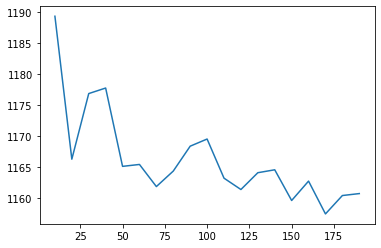

In [64]:
estimator_range = list(range(10,200,10))
RMSElist = []

for estimator in estimator_range:
  RF=RandomForestRegressor(n_estimators=estimator)
  RF.fit(X_train,y_train)
  RMSElist = RMSElist + [np.sqrt(mean_squared_error(RF.predict(X_test),y_test))]

plt.plot(estimator_range,RMSElist)

In [65]:
# This tells us that the minimum root mean squared error can be found at 170 estimators,
estimator_range[RMSElist.index(min(RMSElist))]

170

In [66]:
X_train.shape

(6392, 24)

In [71]:
RF = RandomForestRegressor(n_estimators=170, min_samples_split=150,min_samples_leaf=8,max_features='auto')
RF.fit(X_train,y_train)
score = RF.score(X_test,y_test)
print(score)
print(np.sqrt(mean_squared_error(RF.predict(X_test),y_test)))

0.6030812423912058
1082.8430406196958


In [68]:
RF.feature_importances_

array([2.96323080e-04, 5.57566993e-05, 8.40749834e-05, 3.25580204e-04,
       7.99088419e-04, 3.54594506e-04, 1.10074227e-03, 1.50185612e-04,
       1.03532244e-03, 8.70580414e-04, 2.44763902e-04, 4.07931656e-05,
       1.70727065e-04, 4.83220203e-04, 6.37841924e-04, 4.08394854e-04,
       2.96565844e-01, 2.26443300e-03, 2.14324776e-03, 1.19112143e-01,
       1.02426017e-02, 1.06729554e-02, 5.51492772e-01, 4.48014096e-04])

Baking Goods, Score: 0.0003
Breads, Score: 0.0001
Breakfast, Score: 0.0001
Canned, Score: 0.0003
Dairy, Score: 0.0008
Frozen Foods, Score: 0.0004
Fruits and Vegetables, Score: 0.0011
Hard Drinks, Score: 0.0002
Health and Hygiene, Score: 0.0010
Household, Score: 0.0009
Meat, Score: 0.0002
Others, Score: 0.0000
Seafood, Score: 0.0002
Snack Foods, Score: 0.0005
Soft Drinks, Score: 0.0006
Starchy Foods, Score: 0.0004
Grocery Store, Score: 0.2966
Supermarket Type1, Score: 0.0023
Supermarket Type2, Score: 0.0021
Supermarket Type3, Score: 0.1191
Item_Weight, Score: 0.0102
Item_Visibility, Score: 0.0107
Item_MRP, Score: 0.5515
Item_Fat_Content_Num, Score: 0.0004


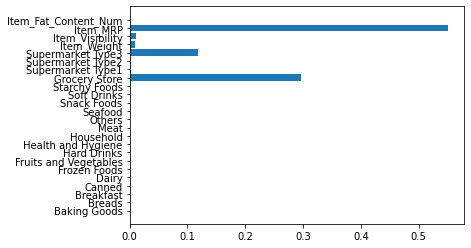

In [69]:
colnames = X_test.columns
RFimp = []

for i,v in enumerate(RF.feature_importances_):
  print(colnames[i] + ', Score: %.4f' % (v))
  RFimp = RFimp + [v]

plt.barh(colnames,RFimp);

The three features with the highest importance are:
1. Item_MRP
2. Grocery Store
3. Supermarket Type3

The other features have very low importances compared to these three columns. 

In [70]:
rf_features = pd.DataFrame({'feature':X_train.columns, 'feature_importance': RF.feature_importances_})
rf_features.sort_values(by = 'feature_importance',inplace=True)

rf_features.head()

# plt.figure(figsize=(12,5))
# plt.barh(rf_features['feature'],rf_features['feature_importance'])

,feature,feature_importance
11,Others,0.000041
1,Breads,0.000056
2,Breakfast,0.000084
7,Hard Drinks,0.000150
12,Seafood,0.000171
